The Deutsch algorithm on one qubit allows to determine whether a function is constant (constant 0 or constant 1) or balanced (identity or negation) by performing one measurrement of the qubit.
If the measurement outcome is <b>0</b>, then the function is <b>constant</b>. If the measurement outcome is <b>1</b>, then the function is <b>balanced</b>.

### Import modules

In [1]:
import qiclib as ql
from qiclib.code import *
from qiclib.packages.qiskit.QiController_backend import QiController_backend
from qiclib.packages.qiskit.QiController_provider import QiController_provider

QKIT configuration initialized -> available as qkit.cfg[...]


/home/lukas/Development/qup_client/src/qiclib/packages/qkit_polyfill.py:38: UserWarning: If you intend to use the QiController together with Qkit, do not forget to start it with qkit.start() before creating the QiController instance.
  warnings.warn(


### Call QiController backend Slot3

In [2]:
qic = ql.QiController("slot3-platform")

[QiController] qiclib version: 1.0.0 +66 (d4cbf0e7, 18.09.2024 13:01) <dirty>
[QiController] Establishing remote connection to slot3-platform...
[QiController] Detected QiController running on ZCU111 board
[QiController] Firmware build time: 13.09.2024 14:11:22 (Revision 779E92BA)
[QiController] Firmware with 6 digital unit cells detected.


### Add coupling map of qubits

In [3]:
# Add coupling map of qubits q0 and q1 (or q1 and q0) subject to the CNOT operation
coupling_map = [[0, 1]]

### Define the sample

In [4]:
# Define the sample of 3 cells; 2 cells correspond the 2 qubits of the circuit, and the 3rd cell is used
# for coupling q0 and q1
sample = QiSample(3)

# First cell corresponds to the first qubit of the circuit
sample[0]["rec_pulse"] = 116e-9  # s readout pulse length
sample[0]["rec_length"] = 100e-9  # s recording window size
sample[0]["rec_frequency"] = 60e6  # Hz readout pulse frequency
sample[0]["manip_frequency"] = 80e6  # Hz control pulse frequency
sample[0]["rec_offset"] = 20e-9  # s electrical delay
sample[0]["pi"] = 160e-9  # s Pi pulse duration
sample[0]["T1"] = 2e-6  # s decoherence time
sample[0]["T2"] = 3e-6  # s dephasing time

# Second cell corresponds to the second qubit of the circuit
sample[1]["rec_pulse"] = 116e-9  # s readout pulse length
sample[1]["rec_length"] = 100e-9  # s recording window size
sample[1]["rec_frequency"] = 90e6  # Hz readout pulse frequency
sample[1]["manip_frequency"] = 80e6  # Hz control pulse frequency
sample[1]["rec_offset"] = 20e-9  # s electrical delay
sample[1]["pi"] = 160e-9  # s Pi pulse duration
sample[1]["T1"] = 2e-6  # s decoherence time
sample[1]["T2"] = 3e-6  # s dephasing

# One additional cell to couple the two qubits q0 and q1, and apply the CNOT gate
sample[2]["gauss_on_pulse_length"] = 24e-9  # s
sample[2]["rectangular_pulse_length"] = 132e-9  # s
sample[2]["gauss_off_pulse_length"] = 24e-9  # s
sample[2]["pulse_frequency"] = 854e6  # Hz

### Amplitude calibration

In [5]:
qic.cell[0].manipulation.amplitude_calibration = (0.5, 0.5)
qic.cell[1].manipulation.amplitude_calibration = (0.5, 0.5)

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

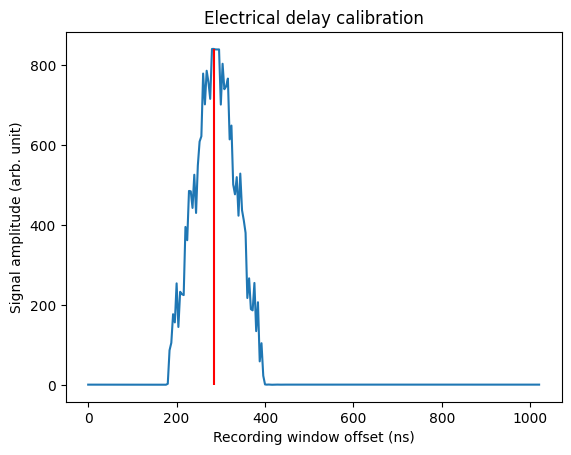

Optimal offset: 284.0 ns


HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

Mirror sideband is -13.8 dB suppressed at recording input


Mirror sideband is 13.85 dB stronger than the actual signal at the recording input. Are maybe I and Q components swapped at the mixer?

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

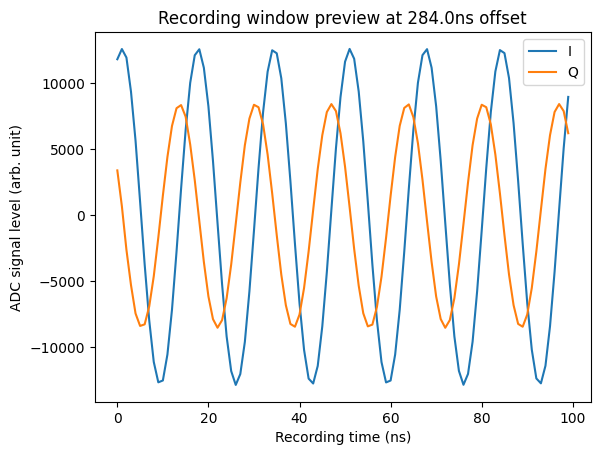

In [6]:
ql.init.calibrate_readout(qic, sample, averages=1000)

In [7]:
with QiJob() as job_test:
    q = QiCells(1)

    ql.jobs.Readout(q[0], "result")

job_test.run(qic, sample, averages=1000, data_collection="iqcloud")

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

In [8]:
result = job_test.cells[0].data("result")

### State calibration

In [9]:
from qiclib.packages.utility import calculate_stater_config

# Enter the coordinates of the seperation line to each cell of the sample seperately
qic.cell[0].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)
qic.cell[1].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)

### Call QiController provider and define backend

In [10]:
# Call the QiController hardware provider with the specified sample
provider = QiController_provider(qic, sample, coupling_map)

In [11]:
# Create a backend based on the given hardware provider and the sample
backend = QiController_backend(provider)

### Deutsch Algorithm

In [12]:
# importing Qiskit
from qiskit import QuantumCircuit

# import basic plot tools
from qiskit.visualization import plot_histogram

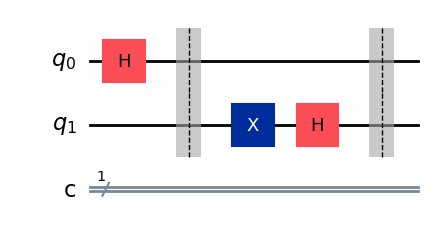

In [13]:
# Number of qubits
n = 1

# Create quantum circuit. n=1 qubits +1 ancilla
circuit = QuantumCircuit(2, 1)

# Apply H-gates
circuit.h(0)
circuit.barrier()

# Put the ancilla qubit in state |->
circuit.x(1)
circuit.h(1)

circuit.barrier()
circuit.draw(output="mpl")

### Constant 0

When we integrate the constant_0 sub-circuit in the Deutsch circuit, the measurement outcome of the qubit is expected to be 0.

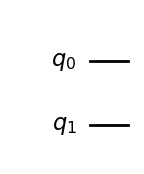

In [14]:
constant_0 = QuantumCircuit(n + 1)

constant_0.draw(output="mpl")

### Constant 1

When we integrate the constant_1 sub-circuit in the Deutsch circuit, the measurement outcome of the qubit is expected to be 0.

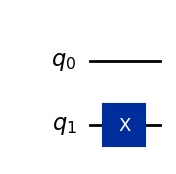

In [15]:
constant_1 = QuantumCircuit(n + 1)

constant_1.x(n)

constant_1.draw(output="mpl")

### Identity

When we integrate the identity sub-circuit in the Deutsch circuit, the measurement outcome of the qubit is expected to be 1.

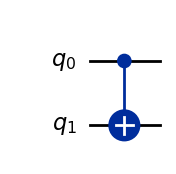

In [16]:
identity = QuantumCircuit(n + 1)

for qubit in range(n):
    identity.cx(qubit, n)

identity.draw(output="mpl")

### Negation

When we integrate the negation sub-circuit in the Deutsch circuit, the measurement outcome of the qubit is expected to be 1.

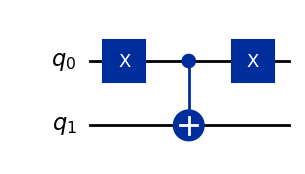

In [17]:
negation = QuantumCircuit(n + 1)

for qubit in range(n):
    negation.x(qubit)
    negation.cx(qubit, n)
    negation.x(qubit)

negation.draw(output="mpl")

Integrate the different sub-circuits in the Deutsch circuit and measure the qubit once to verify whether the input function is constant or balanced.

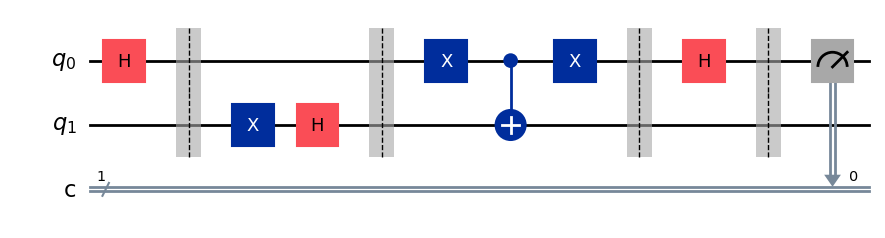

In [18]:
# Add oracle
deutsch_circuit = circuit.compose(negation)
deutsch_circuit.barrier()

# Repeat H-gate
deutsch_circuit.h(0)
deutsch_circuit.barrier()

# Measure
deutsch_circuit.measure(0, 0)

# Display circuit
deutsch_circuit.draw(output="mpl")

In [19]:
# Create a job by running the circuit on the backend for a number of shots
job = backend.run(deutsch_circuit, 1)

HTML(value="<table style='width:100%'><tr><td> (0/1) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1)

In [20]:
# Retrieve the measurement results in terms of counts
counts = job.get_counts()

In [21]:
print(counts)

{'000': np.uint32(0), '001': np.uint32(1)}


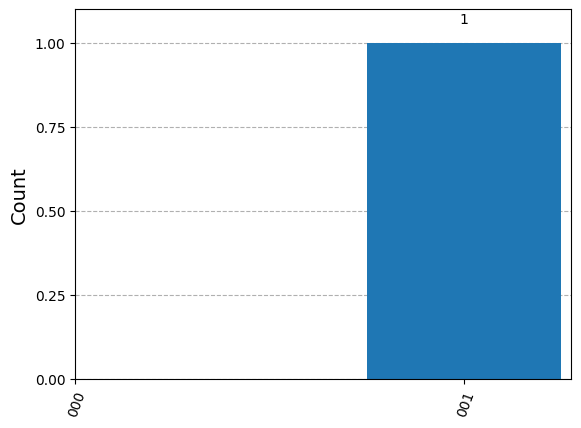

In [22]:
# Display the probability distribution of the quantum states
plot_histogram(counts)